# Churn Analysis
Data retrieved from: https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/
> A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand **who is leaving**.

**Why?**  
It is important for companies to asses whether a client is likely to leave or not; which variables have a bigger effect in churn; and what, if anything, retains the client.

Predicting *churn* is a classification problem since the target variable is whether or not the client is likely to leave. Of course, as with any other ML problem, the better we generalize the data to unseed datapoints, the better the model is.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from collections import defaultdict

plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["figure.dpi"] = 100

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

class DataframeSelector(BaseEstimator, TransformerMixin):
    """
    ScikitLearn class to select a subset of the columns
    in a pandas dataframe 
    """
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns].values
    
class LabelNdBinarizer(BaseEstimator, TransformerMixin):
    """
    Transorm a bi-dimensional categorical numpy array ('object'), i.e.,
    a Matrix, into a single OHE matrix.
    """
    def __init__(self):
        self.all_classes_ = []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xout = None
        _, nfeats = X.shape
        for ix in range(nfeats):
            lab_bin = LabelBinarizer()
            bin_X = lab_bin.fit_transform(X[:, ix])
            self.all_classes_.append(lab_bin.classes_)
            if Xout is None:
                Xout = bin_X
            else:
                Xout = np.c_[Xout, bin_X]
        return Xout

Load the data and look at shape

In [3]:
url = "https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv"
r = requests.get(url)
churn = pd.read_csv(StringIO(r.text), na_values=" ")
churn.shape

(7043, 21)

In [48]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

As always, we divide the data into train and test sets. We will only be working with our training dataset all all throughout the EDA and model evaluation.  

In [5]:
train, test = train_test_split(churn, test_size=0.2, random_state=42)
train.shape, test.shape

((5634, 21), (1409, 21))

Let us begin by looking at at the proportion of those who churn against those who did not churn.

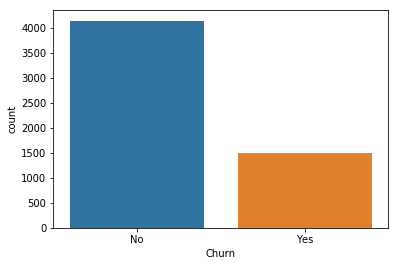

In [49]:
sns.countplot(x="Churn", data=train)

In [7]:
def plot_density_cat(df, contvar, catvar, **kwargs):
    """
    Plot a density distribution segregated by a categorical variable
    
    Parameters
    ----------
    df: DataFrame
    contvar: str
        Name of the continous variable
    catvar: str
        Name of the categorical variable 
        
    Returns
    -------
    None
        Plots the graph
    """
    categories = df[catvar].unique()
    for cat in categories:
        segregation = df.query(f"{catvar} == '{cat}'")[contvar]
        sns.distplot(segregation, hist_kws={"alpha":0.5,  "label":cat}, kde=False, norm_hist=True)
    plt.legend()

As a fist approximation to see what differentiates these two groups, lest's focus on the density of the Montly charges, segregated by those who churn and those who did not.

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


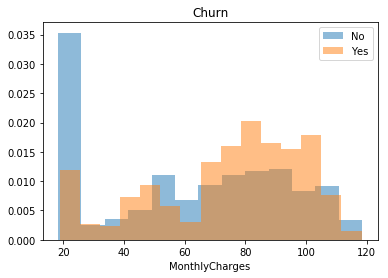

In [8]:
plot_density_cat(train, "MonthlyCharges", "Churn")
plt.title("Churn");

Those who churn seem to have a higher sample proportion in montly charges at around 70+, in contrast with those who stayed; meaning that the higher the montly charge, the higher the likelyhood of a person is to churn.

In [51]:
train.loc[:, "Churn_bool"] = train.Churn.apply(lambda r: 1 if r == "Yes" else 0)

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gerardoduran/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


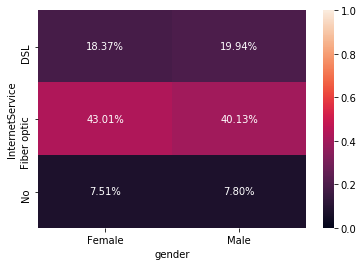

In [52]:
churned = train.pivot_table(values="Churn_bool", columns="gender", index="InternetService")
sns.heatmap(churned, annot=True, fmt="0.2%", vmin=0, vmax=1);

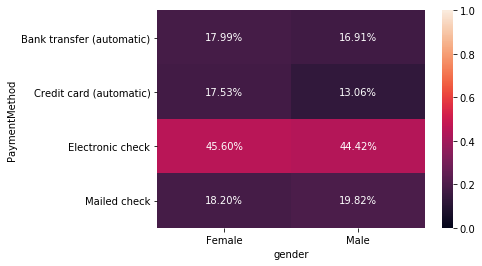

In [53]:
churned = train.pivot_table(values="Churn_bool", columns="gender", index="PaymentMethod")
sns.heatmap(churned, annot=True, fmt="0.2%", vmin=0, vmax=1);

As far as gender goes, there seems to be no clear distinction in churning rates. On the other hand, people with 'Electronic Check' as payment method do seem to have a significant higher churning rate than any other payment method

There seems to be a high churning ratio among those who pay with electronic check and have a Fiber optic as internet service

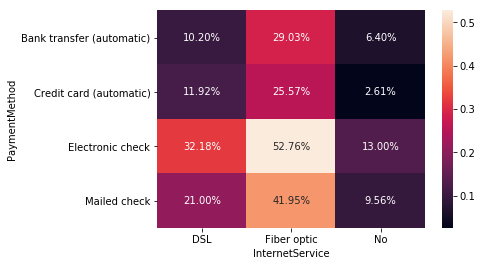

In [54]:
sns.heatmap(train.pivot_table(index="PaymentMethod", columns="InternetService", values="Churn_bool"),
            fmt="0.2%", annot=True)
plt.savefig("/Users/gerardoduran/Desktop/SBLII/sentiment/service_payment_churn.pdf")

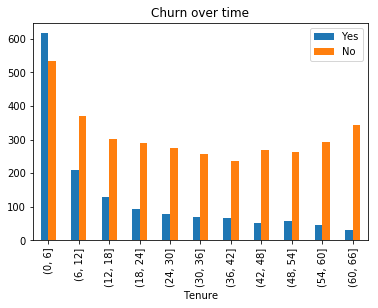

In [14]:
bins = [i * 6 for i in range(12)]
churn_yes = pd.value_counts(pd.cut(train.query("Churn == 'Yes'").tenure, bins))
churn_no = pd.value_counts(pd.cut(train.query("Churn == 'No'").tenure, bins))
churn_yes.name = "Yes"
churn_no.name = "No"
over_time_churn = pd.DataFrame([churn_yes, churn_no]).T
over_time_churn.plot(kind="bar", title="Churn over time")
plt.xlabel("Tenure");

As time passes, people who do not leave seem to be more likely to stay the periods thereafter.

In [16]:
# Let us drop the variable we created for the EDA, as we will not
# be using it to train the model
train.drop("Churn_bool", axis=1, inplace=True)

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Onto the ML model!
### Decision Trees and Random Forests

In this segment we turn to the question *what is actually making customers leave?* We will explore two related models: decision trees and random forests: an ensemble of decision trees

In [20]:
# In order to create the ML pipeline, we divide
# all columns (features) according to their dtype
void_cols = ["customerID", "Churn"]
features_dtypes = defaultdict(list)
for col, dtype in train.dtypes.iteritems():
    if col not in void_cols:
        features_dtypes[dtype.name].append(col)

**Decision Trees**  
Decicion trees are versitile and easy to interpret models. A telecomunications company migh be interested in this kind of models since it provides an easy-to-interpret overview of the problem. Decision trees, as their name suggest, provide a map from features (age of the person, tenure, monthly charges, etc.) to outcome vía a binary tree. The first node of this tree is usually an *important* feature, answering one question from either node takes us to another binary tree wherby the procedure gets repeated until we arrive at the end of the tree.

----
**Building the model**  
The first step in building our model will is to create the pipeline in which variables will be transformed so that the model can be trained.

In [30]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer

cat_pipeline = Pipeline([
    ("feature_selection", DataframeSelector(features_dtypes["object"])),
    ("label_binarizer", LabelNdBinarizer())
])

num_dtypes = [*features_dtypes["int64"], *features_dtypes["float64"]]
num_pipeline = Pipeline([
    ("feature_selection", DataframeSelector(num_dtypes)),
    ("imputer", Imputer())
])

pipeline = FeatureUnion([
    ("cat_pipeline", cat_pipeline),
    ("num_pipeline", num_pipeline)
])

In [42]:
dtree = DecisionTreeClassifier(max_depth=2)
X_train = pipeline.fit_transform(train)
y_train  = (train.Churn == "Yes").values * 1

In [43]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
# Naming of categorical and numerical features.
# We consider 'object' objects as one feature dtype
# and 'int0, 'float' as another feature dtype
cat_name_feats = []
for c in train.columns:
    if c not in void_cols and train[c].dtype == "object":
        unique_vals = train[c].unique()
        n_unique_vals = len(unique_vals)
        if n_unique_vals == 2:
            cat_name_feats.append(c)
        else:
            for val in unique_vals:
                cat_name_feats.append(f"{c}_{val}")

num_name_feats = [c for c in train.columns if c not in void_cols and train[c].dtype != "object"]
name_feats = [*cat_name_feats, *num_name_feats]

In [45]:
export_graphviz(
    dtree,
    rounded=True,
    filled=True,
    class_names=["Yes", "No"],
    feature_names=name_feats,
    out_file="./images/tree.dot"
)

In [55]:
%%bash
dot -Tpng "./images/tree.dot" -o "./images/tree.png"

![tree](./images/tree.png)

From the diagram above we note that if a customer were to have a contract less than one year, its probability of leaving is almost 100%! To note this


### Better Model Selection

In [41]:
from sklearn.model_selection import GridSearchCV
params = 
dtree_cv = GridSearchCV(dtree)

### Evaluating the model

Assesing the final training *accuracy* score of the model

In [37]:
dtree.score(X_train, y_train)

0.78895988640397585

The training accuracy of the model provides us with only a glimpse on how really the model works. In order to better asses the generalization of the model, we turn to the $k$-fold cross validation method

In [40]:
from sklearn.model_selection import cross_val_score
cross_val_score(dtree, X_train, y_train, scoring="accuracy", cv=10, n_jobs=-1).mean()

0.78220780662317202

A slightly lower value than the in-train performance.